# Meli Data Science Challenge
## Andrés Zamora

### Caso de negocio
Dentro del marketplace existen productos similares o idénticos entre sí (son
productos vendidos por distintos sellers, en la api puedes obtener y descargar los
títulos e incluso las imágenes!). ¿Cómo buscar dichos ítems para agruparlos y
volverlos comparables entre sí? Esto permitiría mejorar la experiencia ante muchas
opciones similares.

### Planteamiento inicial
- **Objetivo**: Sistema que pueda encontrar productos iguales entre sí a través de variables disponibles en el [API](https://developers.mercadolibre.com.ar/en_us/api-docs) de [items](https://api.mercadolibre.com/items/#options) de MercadoLibre.
- **Información útil disponible**:
    - Título (texto): Nombre del producto.
    - Thumbnail (imagen): Imagen del producto.
    - Dominio / Categoría (texto)
    - [Atributos](https://developers.mercadolibre.com.ar/es_co/atributos):
        - Marca (texto)
        - Tags (texto)
        - Modelo (texto)
        - Código de barras (texto)
- **Propuesta**: Utilizar procesamiento de texto e imágenes para determinar, a partir de las variables presentadas anteriormente, la similaridad de un producto con otros productos de la misma categoría. Luego, escoger un umbral de similaridad para determinar si dos o más productos son iguales, y obtener el listado de estos.

In [1]:
import unicodedata
import warnings
from dataclasses import dataclass
from functools import lru_cache
from typing import Protocol, Type

import pandas as pd
import matplotlib.pyplot as plt
import requests
import spacy
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

warnings.filterwarnings("ignore")
pd.options.display.max_columns = 100

figsize=(8,5)
dpi=100

plt.rc('axes')
plt.rc('figure')
plt.rc('figure', figsize=figsize, dpi=dpi)
sns.set_context('notebook')
sns.set_palette("pastel")

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Análisis Exploratorio

Escogemos trabajar con el catálogo de Colombia 🇨🇴

In [2]:
@dataclass
class MeLiClient:
    site: str

    def get_categories(self) -> pd.DataFrame:
        url = f"https://api.mercadolibre.com/sites/{self.site}/categories"
        return pd.DataFrame(requests.get(url).json())

    def get_items_in_category(self, category_id: str, offset=0) -> pd.DataFrame:

        url = f"https://api.mercadolibre.com/sites/{self.site}/search?category={category_id}&offset={offset}"
        request = requests.get(url)
        items = request.json()
        try:
            return pd.DataFrame(items["results"])
        except Exception:
            return pd.DataFrame()

    def get_all_items_in_category(self, category_id: str) -> pd.DataFrame:

        offset = 0
        results = []

        result = self.get_items_in_category(category_id)
        results.append(result)

        while len(result) > 0:
            offset += 50

            result = self.get_items_in_category(category_id, offset=offset)
            results.append(result)

        return pd.concat(results)


site = "MCO"
meli = MeLiClient(site)
meli


MeLiClient(site='MCO')

Para acotar el alcance del reto, asumimos que dos productos iguales pertenecen a la misma categoría. Escogemos la categoría *Electrónica, Audio y Video* para trabajar durante este reto.

In [3]:
categories = meli.get_categories()
categories.query("id=='MCO1000'")


,id,name
17,MCO1000,"Electrónica, Audio y Video"


In [4]:
# https://developers.mercadolibre.com.ar/es_co/atributos
# http://www.heikopaulheim.com/docs/swj2018_product_data.pdf

# items[items["attributes"].apply(lambda sku: 'DESCRIPTIVE_TAGS' in (x["id"] for x in sku))] # empty
# items[items["attributes"].apply(lambda sku: 'PRODUCT_FEATURES' in (x["id"] for x in sku))] # empty


Cargamos el listado de productos pertenecientes a esta categoría.

In [5]:
def get_attribute_value(attributes: list, attribute_name: str):
    return next(
        (x["value_name"] for x in attributes if x["id"] == attribute_name),
        None,
    )


def build_dataset(
    meli: MeLiClient,
    category_id: str,
    features: list[str],
    attributes: list[str],
    save=True,
):

    items = meli.get_all_items_in_category(category_id)
    df = items[features]

    for attribute in attributes:
        df[attribute.lower()] = items.attributes.apply(
            get_attribute_value, attribute_name=attribute
        )

    df = df.drop(columns="attributes").dropna(how="all", axis=1).reset_index(drop=True)

    if save:
        df.to_csv(f"{category_id}_items.csv")

    return df


FEATURES = ["id", "title", "thumbnail", "domain_id", "attributes"]
INTERESTING_ATTRIBUTES = ["GTIN", "BRAND", "MODEL"]
category = "MCO1000"  # categories.id.sample().squeeze()

df = build_dataset(meli, category, FEATURES, INTERESTING_ATTRIBUTES)
df


,id,title,thumbnail,domain_id,brand,model
0,MCO618049088,Audífonos Sony Zx Series Mdr-zx110 Negro,http://http2.mlstatic.com/D_975252-MLA45258514...,MCO-HEADPHONES,Sony,MDR-ZX110
1,MCO627599757,Mini Drone Dji Mavic Mini 2 Drdji018 Fly More ...,http://http2.mlstatic.com/D_888397-MLA47979312...,MCO-DRONES,DJI,Mini 2
2,MCO616438574,Audífonos In-ear Jbl Tune 110 Black,http://http2.mlstatic.com/D_798368-MLA46444369...,MCO-HEADPHONES,JBL,110
3,MCO838086582,Soporte North Bayou Nb-p4 De Pared Para Tv/mon...,http://http2.mlstatic.com/D_831097-MLA46523626...,MCO-TV_AND_MONITOR_MOUNTS,North Bayou,NB-P4
4,MCO870314784,Google Chromecast 3.ª Generación Full Hd Carbón,http://http2.mlstatic.com/D_877407-MLA45315730...,MCO-STREAMING_MEDIA_DEVICES,Google,Chromecast
...,...,...,...,...,...,...
1045,MCO592095546,Decodificador Tdt Dvb T2 Antena Wifi Youtube H...,http://http2.mlstatic.com/D_797539-MCO49316716...,MCO-TV_RECEIVERS_AND_DECODERS,DXG,DXG-2122
1046,MCO826351034,Cabina Sonido Recargable Bluetooth 7000w Micró...,http://http2.mlstatic.com/D_726509-MCO48062721...,MCO-SPEAKERS,Quality,C-301
1047,MCO607936979,"Batería 18650 Panasonic Ncr18650b, Liitokala P...",http://http2.mlstatic.com/D_710448-MCO44105884...,MCO-CELL_BATTERIES,Panasonic,LiitoKala NCR18650B
1048,MCO495629897,Grabador Micrófono Voz Audio Digital Profesion...,http://http2.mlstatic.com/D_885565-MCO44628269...,MCO-DIGITAL_VOICE_RECORDERS,IC 8GB,IC RECORDER


In [6]:
print(f"Existen {len(df.id.unique())} productos distintos")

Existen 1050 productos distintos


Ejemplos de thumbnails
![Audífonos](http://http2.mlstatic.com/D_975252-MLA45258514131_032021-I.jpg)
![Audífonos](http://http2.mlstatic.com/D_877407-MLA45315730961_032021-I.jpg)
![Audífonos](http://http2.mlstatic.com/D_691827-MCO45442068331_042021-O.jpg)
![Audífonos](http://http2.mlstatic.com/D_892089-MCO44006453797_112020-O.jpg)
Pueden tener tamaños diferentes
Productos similares tienen thumbnails similares, pero no iguales.
Productos diferentes también pueden tener thumbnails similares (eg. audífonos)

Total domains: 60. Showing the top 30.
Están estandarizadas


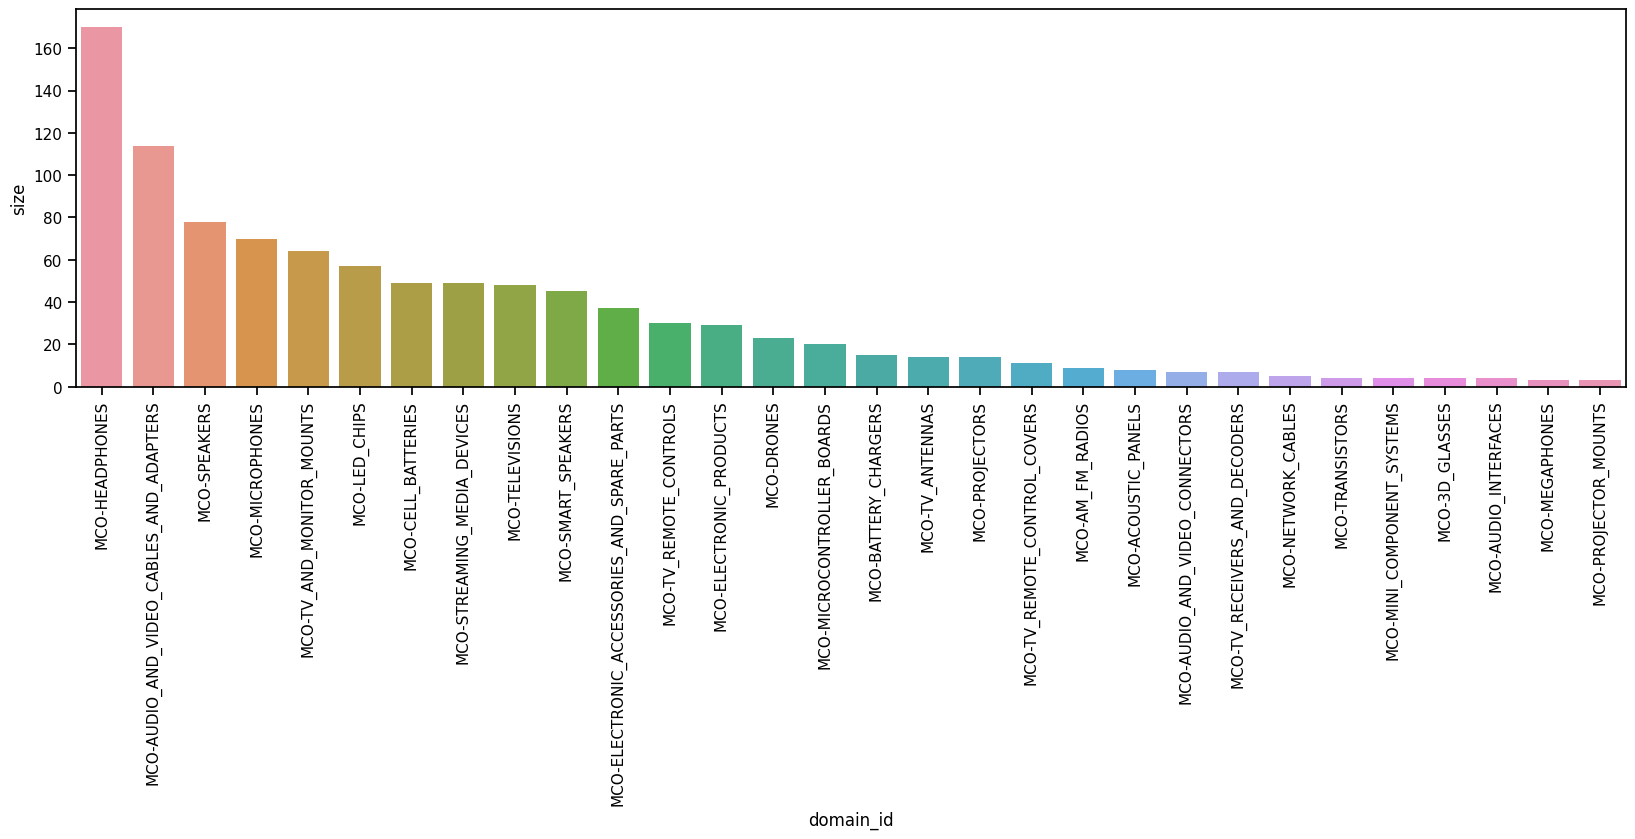

In [7]:
show=30
cnt=df.groupby("domain_id", as_index=False).size().sort_values("size", ascending=False)

print(f"Total domains: {len(cnt)}. Showing the top {show}.")
print("Están estandarizadas")
plt.figure(figsize=(20,5))
sns.barplot(data=cnt.head(show), y="size", x="domain_id")
_=plt.xticks(rotation=90)

Total brands: 351. Showing the top 50.
Algunas marcas aparentemente idénticas tienen nombres similares, pero no iguales (Genérica-Genérico / WGINGENIERIA-WG Ingenieria)


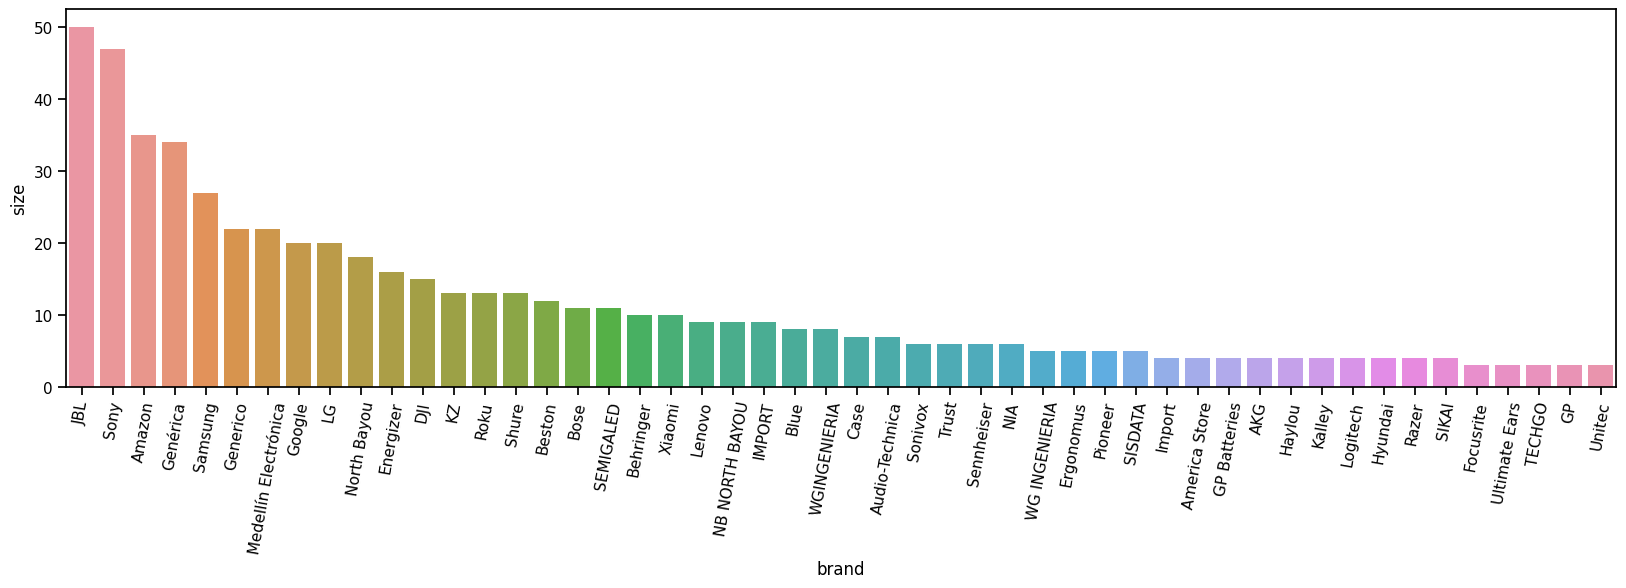

In [8]:
show=50
cnt=df.groupby("brand", as_index=False).size().sort_values("size", ascending=False)

print(f"Total brands: {len(cnt)}. Showing the top {show}.")
print("Algunas marcas aparentemente idénticas tienen nombres similares, pero no iguales (Genérica-Genérico / WGINGENIERIA-WG Ingenieria)")
plt.figure(figsize=(20,5))
sns.barplot(data=cnt.head(show), y="size", x="brand")
_=plt.xticks(rotation=80)


### Solución

Preprocesar y tokenizar la información de títulos de productos:
- Normalizar acentos (unicode)
- Normalizar capitalización y espacios en blanco
- Eliminar puntuación y *stopwords*
- Otras ideas:
    - Corregir ortografía

In [9]:
# Global Preprocessing Utils

nlp = spacy.load("es_core_news_md")


def preprocessor(text: str):
    text = unicodedata.normalize("NFKD", text)
    return text.lower().strip()


def tokenizer(text: str):
    doc = nlp(text)  # probably overkill using spacy for this but ok
    tokens = [word.lemma_ for word in doc if not word.is_stop and not word.is_punct]
    return tokens

txt="Hola mamá!"
print(f"Texto original: {txt}")
print(f"Texto procesado: {tokenizer(preprocessor(txt))}")

Texto original: Hola mamá!
Texto procesado: ['hola', 'mamá']


Crear vectores numéricos que representen los títulos de los productos a partir de las palabras que los componen. 

- Bag of Words
- TF-IDF
- Tok2Vec (spacy)
- Otras ideas:
    - Modelos más complejos (huggingface)
    - Modelos afinados a información de retail y marketplace

In [10]:
class Embedding(Protocol):
    @classmethod
    def initialize(cls, corpus: list[str]) -> None:
        ...

    def similarity(self, other: "Embedding") -> float:
        ...


In [11]:
class SpacyEmbedding:
    def __init__(self, text: str):
        self.embedding = nlp(text)

    @classmethod
    def initialize(cls, corpus: list[str]) -> None:
        pass

    def similarity(self, other: "SpacyEmbedding") -> float:
        return self.embedding.similarity(other.embedding)

    def __repr__(self):
        return str(tuple(self.embedding))


In [12]:
class BagOfWordsEmbedding:
    def __init__(self, text: str):
        self.embedding = self.bow.transform([text])[0]
        self.tokens = tokenizer(text)

    @classmethod
    def initialize(cls, corpus: list[str]) -> None:
        cls.bow = CountVectorizer(tokenizer=tokenizer, preprocessor=preprocessor).fit(
            corpus
        )

    def similarity(self, other: "BagOfWordsEmbedding") -> float:
        return cosine_similarity(self.embedding, other.embedding)[0][0]

    def __repr__(self):
        return str(tuple(self.tokens))


In [13]:
class TFIDFEmbedding:
    def __init__(self, text: str):
        self.embedding = self.tfidf.transform([text])[0]
        self.tokens = tokenizer(text)

    @classmethod
    def initialize(cls, corpus: list[str]) -> None:
        cls.tfidf = TfidfVectorizer(tokenizer=tokenizer, preprocessor=preprocessor).fit(
            corpus
        )

    def similarity(self, other: "TFIDFEmbedding") -> float:
        return cosine_similarity(self.embedding, other.embedding)[0][0]

    def __repr__(self):
        return str(tuple(self.tokens))


In [14]:
def find_embeddings(df, embedding_type: Type[Embedding], embedding_cols: tuple[str]):

    embedding_type.initialize(df.title)
    for col in embedding_cols:
        df[f"{col}_embedding"] = df[col].apply(embedding_type)
    return df


EMBEDDING_COLS = ("title",)  # , "brand", "model"]
df = find_embeddings(df, SpacyEmbedding, EMBEDDING_COLS)
df


,id,title,thumbnail,domain_id,brand,model,title_embedding
0,MCO618049088,Audífonos Sony Zx Series Mdr-zx110 Negro,http://http2.mlstatic.com/D_975252-MLA45258514...,MCO-HEADPHONES,Sony,MDR-ZX110,"(Audífonos, Sony, Zx, Series, Mdr-zx110, Negro)"
1,MCO627599757,Mini Drone Dji Mavic Mini 2 Drdji018 Fly More ...,http://http2.mlstatic.com/D_888397-MLA47979312...,MCO-DRONES,DJI,Mini 2,"(Mini, Drone, Dji, Mavic, Mini, 2, Drdji018, F..."
2,MCO616438574,Audífonos In-ear Jbl Tune 110 Black,http://http2.mlstatic.com/D_798368-MLA46444369...,MCO-HEADPHONES,JBL,110,"(Audífonos, In-ear, Jbl, Tune, 110, Black)"
3,MCO838086582,Soporte North Bayou Nb-p4 De Pared Para Tv/mon...,http://http2.mlstatic.com/D_831097-MLA46523626...,MCO-TV_AND_MONITOR_MOUNTS,North Bayou,NB-P4,"(Soporte, North, Bayou, Nb-p4, De, Pared, Para..."
4,MCO870314784,Google Chromecast 3.ª Generación Full Hd Carbón,http://http2.mlstatic.com/D_877407-MLA45315730...,MCO-STREAMING_MEDIA_DEVICES,Google,Chromecast,"(Google, Chromecast, 3.ª, Generación, Full, Hd..."
...,...,...,...,...,...,...,...
1045,MCO592095546,Decodificador Tdt Dvb T2 Antena Wifi Youtube H...,http://http2.mlstatic.com/D_797539-MCO49316716...,MCO-TV_RECEIVERS_AND_DECODERS,DXG,DXG-2122,"(Decodificador, Tdt, Dvb, T2, Antena, Wifi, Yo..."
1046,MCO826351034,Cabina Sonido Recargable Bluetooth 7000w Micró...,http://http2.mlstatic.com/D_726509-MCO48062721...,MCO-SPEAKERS,Quality,C-301,"(Cabina, Sonido, Recargable, Bluetooth, 7000w,..."
1047,MCO607936979,"Batería 18650 Panasonic Ncr18650b, Liitokala P...",http://http2.mlstatic.com/D_710448-MCO44105884...,MCO-CELL_BATTERIES,Panasonic,LiitoKala NCR18650B,"(Batería, 18650, Panasonic, Ncr18650b, ,, Liit..."
1048,MCO495629897,Grabador Micrófono Voz Audio Digital Profesion...,http://http2.mlstatic.com/D_885565-MCO44628269...,MCO-DIGITAL_VOICE_RECORDERS,IC 8GB,IC RECORDER,"(Grabador, Micrófono, Voz, Audio, Digital, Pro..."


In [15]:
df.title_embedding.iloc[0].embedding.vector

array([-1.57036677e-01, -1.27449930e-01,  2.02963337e-01,  1.81800020e+00,
       -1.39067841e+00,  1.01611841e+00, -5.61863363e-01, -5.89203417e-01,
       -1.06117129e-03, -5.59911668e-01,  9.55800042e-02,  1.26803443e-01,
       -9.12093341e-01, -3.44569951e-01, -1.15635669e+00,  3.39016728e-02,
       -9.22848284e-01,  3.67524981e-01, -2.94809997e-01, -1.19448507e+00,
       -6.10980034e-01, -3.06109995e-01,  2.17084989e-01,  2.05259490e+00,
        7.47595608e-01, -1.23138344e+00, -3.41080666e-01,  2.25306824e-01,
        3.33868355e-01,  7.76233375e-01,  4.66222256e-01,  4.99633551e-02,
       -3.14239949e-01, -8.86201620e-01,  1.19142510e-01, -2.77753323e-01,
       -3.74789715e-01,  8.61733481e-02,  1.29951668e+00, -2.55101651e-01,
        8.83711576e-01, -2.83636659e-01,  1.00609995e-01, -9.61765051e-01,
        1.81588337e-01, -1.67453364e-01, -9.17557895e-01,  2.55142659e-01,
        8.84229764e-02, -6.74534857e-01,  4.71100211e-02,  1.37858999e+00,
       -8.83150101e-02, -

Además, construir funciones que dicten la similitud entre dos de estos vectores.
- Similitud:
    - Coseno
    - Euclidiana

In [16]:
def find_similarities(
    df: pd.DataFrame, embedding: Embedding, feature="title_embedding"
):
    similarities = df[feature].apply(embedding.similarity)
    return similarities

x=df.copy()
prod, emb=df.title.iloc[0], df.title_embedding.iloc[0]
x["similarity"]=find_similarities(df, emb)
print(f"Similitudes del producto {prod} a todos los productos del catálogo")
x[["title", "similarity"]]

Similitudes del producto Audífonos Sony Zx Series Mdr-zx110 Negro a todos los productos del catálogo


,title,similarity
0,Audífonos Sony Zx Series Mdr-zx110 Negro,1.000000
1,Mini Drone Dji Mavic Mini 2 Drdji018 Fly More ...,0.558295
2,Audífonos In-ear Jbl Tune 110 Black,0.490392
3,Soporte North Bayou Nb-p4 De Pared Para Tv/mon...,0.321666
4,Google Chromecast 3.ª Generación Full Hd Carbón,0.411028
...,...,...
1045,Decodificador Tdt Dvb T2 Antena Wifi Youtube H...,0.438849
1046,Cabina Sonido Recargable Bluetooth 7000w Micró...,0.387595
1047,"Batería 18650 Panasonic Ncr18650b, Liitokala P...",0.456103
1048,Grabador Micrófono Voz Audio Digital Profesion...,0.495001


Para las otras variables de texto, usar coincidencias exactas. Para limitar el scope del reto, no se usarán las variables de tipo imagen.

Otras ideas:
- Usar similitudes a nivel fonético o a nivel de caracteres

In [17]:
def feature_exact_match(df: pd.DataFrame, feature: str, feature_value):
    return df[feature] == feature_value

brand="Unitec"
x=df.copy()
x["match"]=feature_exact_match(df, "brand", brand)

print(f"Productos de marca {brand}")
x.loc[x.match, ["title", "brand"]]


Productos de marca Unitec


,title,brand
93,Cable Convertidor Adaptador De Hdmi A Vga,Unitec
367,Cable Convertidor Hdmi A Vga Pc Laptop Tv Mon...,Unitec
674,Diadema Audifono Con Microfono Call Center Uni...,Unitec


Algoritmo planteado como solución para buscar todos los productos iguales a uno escogido:
- Utilizando un algoritmo de vectorización, encontrar las similitudes de los títulos de productos todo el catálogo al producto escogido
- Penalizar la similitud de productos cuya marca/dominio no coincida de forma exacta
- Escoger un umbral de similitud para determinar si dos productos son iguales
- Retornar los productos que están por encima de ese umbral

In [18]:
def find_similar_products(
    df: pd.DataFrame,
    product_id: str,
    embedding_feature="title_embedding",
    penalty_features=["brand", "domain_id"],
    penalty_value=0.2,
    threshold=0.85,
):
    details = df.copy()
    product = df.set_index("id").loc[product_id]
    details["similarity"] = find_similarities(
        df, product[embedding_feature], embedding_feature
    )
    details["raw_similarity"] = details.similarity.copy()

    for penalty_feature in penalty_features:
        is_exact_match = feature_exact_match(
            df, penalty_feature, product[penalty_feature]
        )
        details[f"{penalty_feature}_penalty"] = (
            ~is_exact_match * penalty_value if pd.notna(product[penalty_feature]) else 0
        )
        details["similarity"] -= details[f"{penalty_feature}_penalty"]

    products_above_threshold = details[details["similarity"] > threshold]
    similar_products = details.loc[products_above_threshold.index]
    return similar_products, details


prod="MCO618049088"
print(f"Conjunto de productos encontrados como iguales al {prod}")
PENALTY_FEATURES = ("brand", "domain_id", "model")
find_similar_products(df, prod, penalty_features=PENALTY_FEATURES)[0][["id", "title", "domain_id", "brand", "model", "similarity"]]


Conjunto de productos encontrados como iguales al MCO618049088


,id,title,domain_id,brand,model,similarity
0,MCO618049088,Audífonos Sony Zx Series Mdr-zx110 Negro,MCO-HEADPHONES,Sony,MDR-ZX110,1.000000
13,MCO618050413,Audífonos Sony Zx Series Mdr-zx110 Blanco,MCO-HEADPHONES,Sony,MDR-ZX110,0.971582
16,MCO618050281,Audífonos Sony Zx Series Mdr-zx110 Rosa,MCO-HEADPHONES,Sony,MDR-ZX110,0.892729


### Experimentación
Para determinar el desempeño de la solución, se etiquetaron manualmente los productos iguales a 5 items del catálogo

In [19]:
def load_test_dataset(filename: str):
    test_data = pd.read_excel(filename, sheet_name=["test_set", "all"])
    test_set, all = test_data["test_set"], test_data["all"]
    return test_set, all

print(load_test_dataset(
    "test_electronica.xlsx"
)[0].test_id.unique())


['MCO618049088' 'MCO641446794' 'MCO593426721' 'MCO626370015'
 'MCO453389071']


Se plantea la configuración de un experimento con los siguientes parámetros:
- Tipo de vector a utilizar (eg. Bag of Words)
- Variable a vectorizar (eg. Title)
- Variables a penalizar (eg. Marca, Modelo)
- Valor de la penalización (eg. 0.1)
- Valor del umbral (eg. 0.9)

In [20]:
@dataclass(frozen=True)
class SimilarityConfig:
    experiment_name: str
    test_filename: str
    embedding_type: Type[Embedding]
    embedding_feature: str
    penalty_features: tuple[str]
    penalty_value: float
    threshold: float


In [21]:
config = SimilarityConfig(
    experiment_name="demo",
    test_filename="test_electronica.xlsx",
    embedding_type=BagOfWordsEmbedding,
    embedding_feature="title",
    penalty_features=PENALTY_FEATURES,
    penalty_value=0.05,
    threshold=0.7,
)

In [22]:
@lru_cache(16)
def build_testing_data(test_filename, embedding_type, embedding_feature):
    test_set, df = load_test_dataset(test_filename)
    data = find_embeddings(df, embedding_type, [embedding_feature])
    return test_set, data


test_set, data = build_testing_data(
    config.test_filename, config.embedding_type, config.embedding_feature
)


In [23]:
def test_product_matches(
    df: pd.DataFrame, matches: pd.DataFrame, true_matches: list[str]
):

    tp = matches[matches.id.isin(true_matches)]
    fp = matches[~matches.id.isin(true_matches)]
    fn = df[(df.id.isin(true_matches) & (~df.id.isin(matches.id)))]
    tn = df[(~df.id.isin(true_matches) & (~df.id.isin(matches.id)))]

    return tp, fp, fn, tn


test_id = test_set.test_id.iloc[0]
tm = test_set[test_set.test_id == test_id].id
matches, details = find_similar_products(
    df,
    test_id,
    penalty_features=config.penalty_features,
    embedding_feature=config.embedding_feature + "_embedding",
    penalty_value=config.penalty_value,
    threshold=config.threshold,
)
#test_product_matches(data, matches, tm)


Se definen las métricas a utilizar:
- *Precision* (P): Total de *matches* correctos / Total de *matches* encontrados
- *Recall* (R): Total de *matches* correctos / Total de *matches* reales

In [24]:
def get_precision_and_recall(
    true_positives: pd.DataFrame,
    false_positives: pd.DataFrame,
    false_negatives: pd.DataFrame,
    true_negatives: pd.DataFrame,
):
    tp, fp, fn, tn = (
        len(true_positives),
        len(false_positives),
        len(false_negatives),
        len(true_negatives),
    )
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn)
    return precision, recall


P,R=get_precision_and_recall(*test_product_matches(data, matches, tm))
#print(config)
print(f"{P=} {R=}")

P=0.15 R=1.0


Se comprueba el desempeño de un experimento a través de estas métricas a nivel item y a nivel global:

In [25]:
def test_similarity_model(cfg: SimilarityConfig, verbose=True):

    if verbose:
        print(f"building testing data for {cfg}...")
    test_set, data = build_testing_data(
        cfg.test_filename, cfg.embedding_type, cfg.embedding_feature
    )
    test_products = test_set.test_id.unique()
    all_cf = []
    all_matches = []

    if verbose:
        print("finding similar products...")
    for product_id in test_products:
        if verbose:
            print(f"\ntesting {product_id}")
        true_matches = test_set[test_set.test_id == product_id].id
        matches, details = find_similar_products(
            data,
            product_id,
            penalty_features=cfg.penalty_features,
            embedding_feature=cfg.embedding_feature + "_embedding",
            penalty_value=cfg.penalty_value,
            threshold=cfg.threshold,
        )
        confusion_matrix = test_product_matches(data, matches, true_matches)
        precision, recall = get_precision_and_recall(*confusion_matrix)

        if verbose:
            print(f"{precision=}")
            print(f"{recall=}")

        all_cf.append(confusion_matrix)
        all_matches.append(matches)

    if verbose:
        print("finished\n")

    global_confusion_matrix = [pd.concat(df) for df in zip(*all_cf)]
    global_precision, global_recall = get_precision_and_recall(*global_confusion_matrix)
    global_matches = pd.concat(all_matches)
    if verbose:
        print(f"{global_precision=}")
        print(f"{global_recall=}")

    return global_matches, global_precision, global_recall


config = SimilarityConfig(
    experiment_name="bow1",
    test_filename="test_electronica.xlsx",
    embedding_type=BagOfWordsEmbedding,
    embedding_feature="title",
    penalty_features=PENALTY_FEATURES,
    penalty_value=0.15,
    threshold=0.5,
)

_=test_similarity_model(config)


building testing data for SimilarityConfig(experiment_name='bow1', test_filename='test_electronica.xlsx', embedding_type=<class '__main__.BagOfWordsEmbedding'>, embedding_feature='title', penalty_features=('brand', 'domain_id', 'model'), penalty_value=0.15, threshold=0.5)...
finding similar products...

testing MCO618049088
precision=0.3333333333333333
recall=1.0

testing MCO641446794
precision=1.0
recall=1.0

testing MCO593426721
precision=0.7142857142857143
recall=0.8333333333333334

testing MCO626370015
precision=0.2222222222222222
recall=0.6666666666666666

testing MCO453389071
precision=0.2857142857142857
recall=0.6666666666666666
finished

global_precision=0.3939393939393939
global_recall=0.8125


Se comparan varios experimentos determinados sobre un espacio de búsqueda para determinar la mejor configuración:

In [26]:
@dataclass
class ExperimentResults:
    experiment: SimilarityConfig
    precision: float
    recall: float


def run_experiments(experiments: list[SimilarityConfig]):
    results = []
    for experiment in experiments:
        _, precision, recall = test_similarity_model(experiment, verbose=False)
        results.append(ExperimentResults(experiment, precision, recall))

    return results


THRESHOLDS = [0.5, 0.6, 0.7, 0.8, 0.9]
EMBEDDING_TYPES = [BagOfWordsEmbedding, TFIDFEmbedding, SpacyEmbedding]

PENALTY_FEATURES = ("brand", "domain_id", "model")
TEST_FILENAME = "test_electronica.xlsx"
EMBEDDING_FEATURE = "title"
PENALTY_VALUE = 0.15

print(f"{PENALTY_FEATURES=}")
print(f"{PENALTY_VALUE=}")

experiments = [
    SimilarityConfig(
        f"{et.__name__} @ {th}",TEST_FILENAME, et, EMBEDDING_FEATURE, PENALTY_FEATURES, PENALTY_VALUE, th
    )
    for et in EMBEDDING_TYPES
    for th in THRESHOLDS
]

print(f"Ejecutando {len(experiments)} experimentos. Iterando sobre valores del tipo de vector y umbral.")
results = run_experiments(experiments)
print("Finalizado")

PENALTY_FEATURES=('brand', 'domain_id', 'model')
PENALTY_VALUE=0.15
Ejecutando 15 experimentos. Iterando sobre valores del tipo de vector y umbral.
Finalizado


In [27]:
res=pd.DataFrame([{"experiment": r.experiment.experiment_name, "precision":r.precision, "recall":r.recall} for r in results])
res["f1"]=2*(res.precision*res.recall)/(res.precision+res.recall)
res.sort_values("f1", ascending=False)

,experiment,precision,recall,f1
6,TFIDFEmbedding @ 0.6,0.866667,0.8125,0.838710
2,BagOfWordsEmbedding @ 0.7,1.000000,0.6875,0.814815
1,BagOfWordsEmbedding @ 0.6,0.684211,0.8125,0.742857
7,TFIDFEmbedding @ 0.7,1.000000,0.5625,0.720000
3,BagOfWordsEmbedding @ 0.8,1.000000,0.5000,0.666667
8,TFIDFEmbedding @ 0.8,1.000000,0.5000,0.666667
5,TFIDFEmbedding @ 0.5,0.500000,0.8125,0.619048
14,SpacyEmbedding @ 0.9,1.000000,0.4375,0.608696
13,SpacyEmbedding @ 0.8,0.615385,0.5000,0.551724
4,BagOfWordsEmbedding @ 0.9,1.000000,0.3750,0.545455


Se determina el mejor experimento como solución (hasta el momento) al problema:

In [28]:
best_config = SimilarityConfig(
    experiment_name="TFIDFEmbedding @ 0.6",
    test_filename="test_electronica.xlsx",
    embedding_type=TFIDFEmbedding,
    embedding_feature="title",
    penalty_features=("brand", "domain_id", "model"),
    penalty_value=0.15,
    threshold=0.6,
)

matches, precision, recall = test_similarity_model(best_config)
matches


building testing data for SimilarityConfig(experiment_name='TFIDFEmbedding @ 0.6', test_filename='test_electronica.xlsx', embedding_type=<class '__main__.TFIDFEmbedding'>, embedding_feature='title', penalty_features=('brand', 'domain_id', 'model'), penalty_value=0.15, threshold=0.6)...
finding similar products...

testing MCO618049088
precision=1.0
recall=1.0

testing MCO641446794
precision=1.0
recall=1.0

testing MCO593426721
precision=1.0
recall=0.8333333333333334

testing MCO626370015
precision=0.5
recall=0.6666666666666666

testing MCO453389071
precision=1.0
recall=0.6666666666666666
finished

global_precision=0.8666666666666667
global_recall=0.8125


,id,title,thumbnail,domain_id,brand,model,title_embedding,similarity,raw_similarity,brand_penalty,domain_id_penalty,model_penalty
0,MCO618049088,Audífonos Sony Zx Series Mdr-zx110 Negro,http://http2.mlstatic.com/D_975252-MLA45258514...,MCO-HEADPHONES,Sony,MDR-ZX110,"('Audífonos', 'Sony', 'Zx', 'Series', 'Mdr-zx1...",1.000000,1.000000,0.00,0.0,0.00
14,MCO618050413,Audífonos Sony Zx Series Mdr-zx110 Blanco,http://http2.mlstatic.com/D_896816-MLA45258465...,MCO-HEADPHONES,Sony,MDR-ZX110,"('Audífonos', 'Sony', 'Zx', 'Series', 'Mdr-zx1...",0.883912,0.883912,0.00,0.0,0.00
16,MCO618050281,Audífonos Sony Zx Series Mdr-zx110 Rosa,http://http2.mlstatic.com/D_639965-MLA45258510...,MCO-HEADPHONES,Sony,MDR-ZX110,"('Audífonos', 'Sony', 'Zx', 'Series', 'Mdr-zx1...",0.831661,0.831661,0.00,0.0,0.00
92,MCO641446794,Audífonos Audio-technica M-series Ath-m30x Negro,http://http2.mlstatic.com/D_669027-MLA45258905...,MCO-HEADPHONES,Audio-Technica,ATH-M30x,"('Audífonos', 'Audio-technica', 'M-series', 'A...",1.000000,1.000000,0.00,0.0,0.00
46,MCO593426721,Cinta Led Multicolor Rgb Luz 5mts + Control + ...,http://http2.mlstatic.com/D_892089-MCO44006453...,MCO-LED_CHIPS,RGB 5050,RGB 5050,"('Cinta', 'Led', 'Multicolor', 'Rgb', 'Luz', '...",1.000000,1.000000,0.00,0.0,0.00
73,MCO607187019,Cinta Led Multicolor Rgb Luz 5mts + Control + ...,http://http2.mlstatic.com/D_691827-MCO45442068...,MCO-LED_CHIPS,Osblack,Led,"('Cinta', 'Led', 'Multicolor', 'Rgb', 'Luz', '...",0.700000,1.000000,0.15,0.0,0.15
300,MCO623410124,Cinta Led Multicolor Rgb Luz 5050 5mts + Contr...,http://http2.mlstatic.com/D_950823-MCO45377335...,MCO-LED_CHIPS,Comercializadora Nápoles,Cinta led Multicolor RGB,"('Cinta', 'Led', 'Multicolor', 'Rgb', 'Luz', '...",0.636643,0.936643,0.15,0.0,0.15
524,MCO621196527,Cinta Led Multicolor Rgb Luz 5050 5mts + Contr...,http://http2.mlstatic.com/D_964375-MCO45828010...,MCO-LED_CHIPS,NaN,Cinta led Multicolor RGB,"('Cinta', 'Led', 'Multicolor', 'Rgb', 'Luz', '...",0.636643,0.936643,0.15,0.0,0.15
977,MCO856218109,Cinta Led Multicolor Rgb Luz 5mts + Control + ...,http://http2.mlstatic.com/D_700055-MCO49035786...,MCO-LED_CHIPS,TecnoNovedadesCO,CLRGB060TN,"('Cinta', 'Led', 'Multicolor', 'Rgb', 'Luz', '...",0.700000,1.000000,0.15,0.0,0.15
58,MCO626370015,Google Nest Mini 2nd Gen Con Asistente Virtual...,http://http2.mlstatic.com/D_738549-MLA45993657...,MCO-SMART_SPEAKERS,Google,Nest Mini 2nd Gen,"('Google', 'Nest', 'Mini', '2nd', 'Gen', 'Asis...",1.000000,1.000000,0.00,0.0,0.00


### Conclusiones 

- Claramente la calidad del modelo solución puede mejorar muchísimo.
- Vale la pena determinar si para este problema me importa más la *precision* o el *recall* y optimizar sobre esta variable.
- Entender si hay algún patrón en los casos donde se equivoca el algoritmo
- Extender el set de pruebas para obtener resultados de desempeño significativos
- Extender las pruebas a otras categorías
- Intentar con algunas de las ideas alternativas planteadas durante esta presentación
- Intentar con diferentes variables que no se probaron (eg. Color, # Unidades en paquete, Tamaños)
- Integrar este sistema al marketplace a través de un servicio web (probablemente)
- Encontrar métricas para determinar el *usefulness* del proyecto. (eg. ¿sí está agregando valor?)
- Optimizar la velocidad de inferencia hasta el punto adecuado

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=508708c0-8ca0-4b91-b41d-453bb1a669cd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>